# Auto encoder

## Read data

In [1]:
from prepare_data import listTurbines


turbines = listTurbines()
turbines

['CRKALN_001',
 'CRKALN_002',
 'CRKALN_003',
 'CRKALN_004',
 'CRKALN_005',
 'CRKALN_006',
 'CRKALN_007',
 'CRKALN_008',
 'CRKALN_009',
 'CRKALN_010']

In [2]:
from prepare_data import TurbineData


turbineData = TurbineData(turbines[1], verbose=True)
print(turbineData.data3d.shape)
print(turbineData.columns)

(297360, 720, 28)
Index(['datetime', 'avgwindspeed', 'avgpower', 'windspeedstandarddeviation',
       'nacelleposition', 'avgwinddirection', 'availablepowerpublished',
       'avgrotorspeed', 'avgpitchangle', 'avgreactivepower',
       'ambienttemperature', 'avghumidity', 'turbinepressure', 'density',
       'latitude', 'longitude', 'cutoutwindspeed', 'ratedwindspeed',
       'rotordiameter', 'hubheight', 'groundlevelaltitude', 'turbulent',
       'underperformanceprobability', 'overperformanceprobability',
       'turbulentvalid', 'underperformanceprobabilityvalid',
       'overperformanceprobabilityvalid', 'original_feature_count'],
      dtype='object')


### Filter valid data

In [3]:
idPower = turbineData.getIdOfColumn("avgpower")
idWind = turbineData.getIdOfColumn("avgwindspeed")

idPower, idWind

(2, 1)

In [4]:
normalIndices = turbineData.getNormalIndices(
    maxConsecutiveInvalid=5,  # 1 hours of consecutive invalid data
    maxInvalidRate=0.5,
    underperformThreshold=1,  # ignore underperf threshold
)

Valid: 5752
Not underperform: 297360
Normal: 5752


## Split train test

In [5]:
import numpy as np


SEED = 17
TEST_RATIO = 0.2
VAL_RATIO = 0.2


# suffle data
np.random.seed(SEED)
np.random.shuffle(normalIndices)

# split data
n_test = int(len(normalIndices) * TEST_RATIO)
testIndices = normalIndices[:n_test]
trainIndices = normalIndices[n_test:]

n_val = int(len(trainIndices) * VAL_RATIO)
valIndices = trainIndices[:n_val]
trainIndices = trainIndices[n_val:]

print(f"Train: {len(trainIndices)} Val: {len(valIndices)} Test: {len(testIndices)}")

Train: 3682 Val: 920 Test: 1150


In [ ]:
from sklearn.discriminant_analysis import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline

from cls_dataset import toTurbineDatasets


targetFeats = [
    "ambienttemperature",
    "ambienttemperature",
    "ambienttemperature",
    "avgrotorspeed",
    "avgrotorspeed",
]
targetFeatIndices = [turbineData.getIdOfColumn(feat) for feat in targetFeats]

underPerfValidId = turbineData.getIdOfColumn("underperformanceprobabilityvalid")


sortedTrainIndices = trainIndices.copy()
sortedTrainIndices.sort()  # h5py requires sorted indices

trainData2d = turbineData.data3d[sortedTrainIndices, 0, :]
# drop invalid
trainData2d = trainData2d[trainData2d[:, underPerfValidId] == 1]

transformerTrainData = trainData2d[:, targetFeatIndices]
print(f"Train data for scaler and imputer {transformerTrainData.shape}")

stdScaler = StandardScaler()
transformerTrainData = stdScaler.fit_transform(transformerTrainData)

trainSet, valSet, testSet = toTurbineDatasets(
    turbineData.data3d,
    (trainIndices, valIndices, testIndices),
    targetFeatIndices,
    stdScaler.transform,
)

trainSet.save("tmp/trainSet")
valSet.save("tmp/valSet")
testSet.save("tmp/testSet")


# from cls_dataset import TurbineDataset


# trainSet = TurbineDataset.load("tmp/trainSet")
# valSet = TurbineDataset.load("tmp/valSet")
# testSet = TurbineDataset.load("tmp/testSet")

# with open("./train.log", "w") as f:
#     print(trainSet[0][0], file=f)

print(f"Data shape: {trainSet[0][0].shape}")

Train data for scaler and imputer (3501, 5)
Data shape: (1, 720, 5)


## Model

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Encoder(nn.Module):
    def __init__(self, latentDim):
        super().__init__()
        self.latentDim = latentDim
        # 1 learnable embedding for invalid values
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, stride=2, padding=1)  # 5->3
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1)  # 3->2
        self.conv3 = nn.Conv2d(16, 32, kernel_size=2)  # 2->1
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(5728, 2048)
        self.fc2 = nn.Linear(2048, latentDim)

        # debug flag
        self.debug = 0
    def forward(self, x):
        debugging = False
        if self.debug > 0:
            debugging = True
            self.debug -= 1

        x= self.conv1(x)
        x = F.leaky_relu(x)
        if debugging:
            print(f"Conv1: {x.shape}")
            
        x = self.conv2(x)
        x = F.leaky_relu(x)
        if debugging:
            print(f"Conv2: {x.shape}")
            
        x = self.conv3(x)
        x = F.leaky_relu(x)
        if debugging:
            print(f"Conv3: {x.shape}")
            
        x = self.flatten(x)
        x = self.fc1(x)
        x = F.leaky_relu(x)
        x = self.fc2(x)
        return x
    
class Decoder(nn.Module):
    def __init__(self, latentDim):
        super().__init__()
        self.latentDim = latentDim
        self.fc1 = nn.Linear(latentDim, 2048)
        self.fc2 = nn.Linear(2048, 5728)
        self.conv1 = nn.ConvTranspose2d(32, 16, kernel_size=2)
        self.conv2 = nn.ConvTranspose2d(16, 8, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.ConvTranspose2d(8, 1, kernel_size=3, stride=2, padding=1)
        self.debug = 0
    def forward(self, x):
        debugging = False
        if self.debug > 0:
            debugging = True
            self.debug -= 1
        x = self.fc1(x)
        x = F.leaky_relu(x)
        if debugging:
            print(f"FC1: {x.shape}")
            
        x = self.fc2(x)
        x = F.leaky_relu(x)
        if debugging:
            print(f"FC2: {x.shape}")
            
        x = x.view(-1, 32, 179, 1)
        x = self.conv1(x)
        x = F.leaky_relu(x)
        if debugging:
            print(f"Conv1: {x.shape}")
            
        x = self.conv2(x)
        x = F.leaky_relu(x)
        if debugging:
            print(f"Conv2: {x.shape}")
            
        x = self.conv3(x)
        if debugging:
            print(f"Conv3: {x.shape}")
        return x
    
class Autoencoder(nn.Module):
    def __init__(self, latent_dim: int):
        super().__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)
    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed


# test if the model is working
testModel = Autoencoder(1024)
testModel.encoder.debug = 1

# pass a random tensor to the model
x = torch.randn(32, 1, 720, 5)
output = testModel(x)

print(f"Expected output shape: {x.shape}")
print(f"Output shape: {output.shape}")

# print(x[0])
# print(output[0])

del testModel
del x
del output

Conv1: torch.Size([32, 8, 360, 3])
Conv2: torch.Size([32, 16, 180, 2])
Conv3: torch.Size([32, 32, 179, 1])
Expected output shape: torch.Size([32, 1, 720, 5])
Output shape: torch.Size([32, 1, 717, 5])


## Training 

In [ ]:
import copy
from matplotlib import pyplot as plt
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

trainLoader = DataLoader(trainSet, batch_size=64, shuffle=True, pin_memory=True)
valLoader = DataLoader(valSet, batch_size=64, shuffle=False, pin_memory=True)
testLoader = DataLoader(testSet, batch_size=64, shuffle=False, pin_memory=True)

model = Autoencoder(516).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
optimScheduler = ReduceLROnPlateau(optimizer, patience=5, factor=0.2)

# Training loop
num_epochs = 500
earlyStopping = 10
bestValLoss = float("inf")
bestModelState = None
patience = 0

trainLosses = []
valLosses = []

for epoch in range(num_epochs):
    trainLoss = 0

    model.train()

    for x in trainLoader:
        x = x.float().to(device)
        optimizer.zero_grad()

        # Forward pass
        reconstructs = model(x)

        # match reconstructed shape with inputs
        n_timestepsReconstructed = reconstructs.shape[-2]
        x = x[:, :, :n_timestepsReconstructed, :]

        # take temp and rotor speed (they are all the target features)
        # reconstructs = reconstructs[:, :, :, [2, 4]]
        # x = x[:, :, :, [2, 4]]

        loss = criterion(reconstructs, x)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        trainLoss += loss.item()

    trainLoss /= len(trainLoader)
    trainLosses.append(trainLoss)

    # Validation loss
    valLoss = 0

    model.eval()

    with torch.no_grad():
        for x in valLoader:
            x = x.float().to(device)
            reconstructs = model(x)

            n_timestepsReconstructed = reconstructs.shape[-2]
            x = x[:, :, :n_timestepsReconstructed, :]

            reconstructs = reconstructs[:, :, :, [2, 4]]
            x = x[:, :, :, [2, 4]]

            loss = criterion(reconstructs, x)
            valLoss += loss.item()

    valLoss /= len(valLoader)
    valLosses.append(valLoss)

    print(
        f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {trainLoss:.4f}, Val Loss: {valLoss:.4f}"
    )
    
    # Early stopping
    if valLoss < bestValLoss:
        bestValLoss = valLoss
        bestModelState = copy.deepcopy(model.state_dict())
        patience = 0
    else:
        patience += 1
        if patience > earlyStopping:
            break

    optimScheduler.step(valLoss)

# Save the model
torch.save(bestModelState, "autoencoder_cnn.pth")
model.load_state_dict(bestModelState)  # type: ignore

RuntimeError: CUDA error: CUDA-capable device(s) is/are busy or unavailable
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


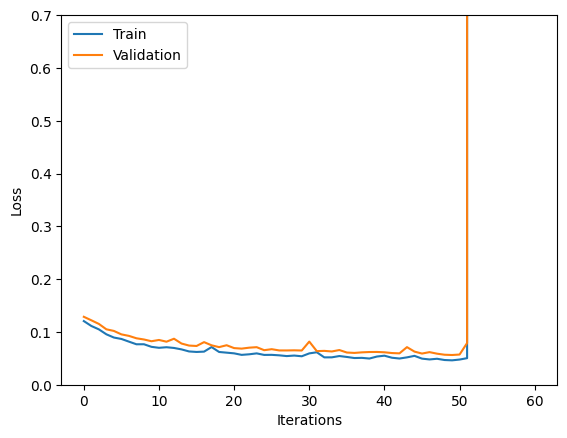

In [ ]:
plt.xlabel("Iterations")
plt.ylabel("Loss")


plt.plot(trainLosses[10:])
plt.plot(valLosses[10:])

plt.ylim(-0, 0.7)

plt.legend(["Train", "Validation"])
plt.show()

## Evaluating

In [ ]:
tempIn = []
tempOut = []

rotIn = []
rotOut = []

testLoss = 0

model.eval()
with torch.no_grad():
    for x in testLoader:
        x = x.float().to(device)
        reconstructs = model(x)

        n_timestepsReconstructed = reconstructs.shape[-2]
        x = x[:, :, :n_timestepsReconstructed, :]
        
        testLoss += criterion(reconstructs[:, :, :, [2, 4]], x[:, :, :, [2, 4]]).item()

        for sample in x.detach().cpu().numpy():
            for channel in sample:
                for timestep in channel:
                    tempIn.append(timestep[2])
                    rotIn.append(timestep[4])
                    
        for sample in reconstructs.detach().cpu().numpy():
            for channel in sample:
                for timestep in channel:
                    tempOut.append(timestep[2])
                    rotOut.append(timestep[4])
                    
testLoss /= len(testLoader)
print(f"Test loss: {testLoss}")


Test loss: 0.05750222099678857


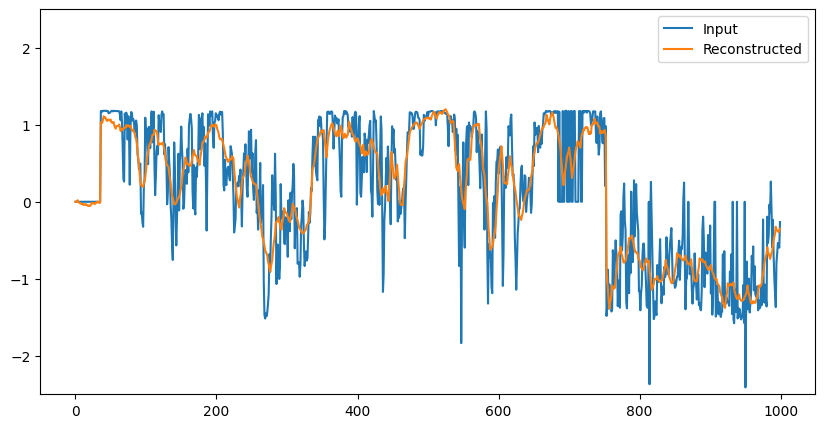

In [ ]:
a = 5700
b = a + 1000

plt.figure(figsize=(10, 5))
plt.plot(rotIn[a:b], label="Input")
plt.plot(rotOut[a:b], label="Reconstructed")
plt.ylim(-2.5, 2.5)
plt.legend()
plt.show()

In [ ]:
tempIn, tempOut = zip(*sorted(zip(tempIn, tempOut)))
rotIn, rotOut = zip(*sorted(zip(rotIn, rotOut)))

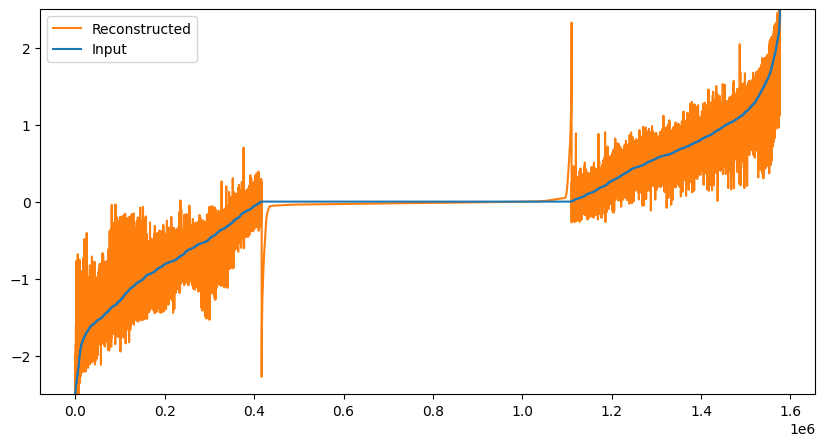

In [ ]:
a = 0
b = len(tempIn)

plt.figure(figsize=(10, 5))
plt.plot(tempOut[a:b], label="Reconstructed", color="#ff7f0e")
plt.plot(tempIn[a:b], label="Input", color="#1f77b4")
plt.ylim(-2.5, 2.5)
plt.legend()
plt.show()
